# Importing Libraries

In [20]:
import pickle
import pandas as pd
import nltk
from operator import itemgetter
import regex as re
from sklearn.model_selection import train_test_split, KFold
from numpy import array
import time
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Logic to handle potential unseen words

In [21]:
def findTag_UnseenWords(word):
    if not re.search(r'\w', word):
        return '.'
    elif word.lower() in pronouns:
        return 'PRON'
    elif re.search(r'\d', word):
        return 'NUM'
    elif re.search(r'(ion\b|ty\b|ics\b|ment\b|ence\b|ance\b|ness\b|ist\b|ism\b)',word):
        return 'NOUN'
    elif word.istitle():
        return 'NOUN'
    elif re.search(r'(ate\b|fy\b|ize\b|\ben|\bem|ing\b|ed\b|es\b)', word):
        return 'VERB'
    elif re.search(r'(\bun|\bin|ble\b|ry\b|ish\b|ious\b|ical\b|\bnon|ful\b|less\b)',word):
        return 'ADJ'
    elif re.search(r'(\T?\?-[0-9]+$)', word):
        return 'X'
    else:
        return 'NOUN'

# Generating Transition Probability table

In [22]:
def sentence_list_to_word_list(train_set):	
	return {word for sent in train_set for word,_ in sent}

def myBigrams(sent):
	bigrams = []
	for i in range(len(sent)-1):
		bigrams.append((sent[i], sent[i+1]))
	return bigrams

def generate_Bigram_Transition_Table(train_set):
	tagBigramProb = pd.DataFrame(0.0,columns=allTags, index=allTags)
	for sent in train_set:
		bi = myBigrams(sent)
		for b1,b2 in bi:
			tagBigramProb.loc[b1[1], b2[1]] += 1
	biGramCount = tagBigramProb.copy()

	for tag in allTags:
		total = sum(tagBigramProb.loc[tag, :])
		if total != 0:
			tagBigramProb.loc[tag, :] = tagBigramProb.loc[tag, :].div(total) 
	
	return tagBigramProb, biGramCount

# Generating Emission probablity table

In [23]:
def generate_Emission_Prob_Table(train_set):
  emissionProbTable = pd.DataFrame(0.0, columns=allTags, index = allWords)
  for sent in train_set:
    for word,tag in sent:
      emissionProbTable.loc[ word, tag] += 1
  for tag in allTags:
    total = sum(emissionProbTable[tag])
    if total != 0:
      emissionProbTable[tag] = emissionProbTable[tag].div(total)

  return emissionProbTable

# Function to assign POS tags to each word in the list

In [24]:
def POS_tag_assign(words_list, num_words):

	output_tags = ['']
	output_tags *= num_words

	for i in range(num_words):	
		# Storing transition probability values of current word as a lis of tuples	
		# The first word in document is considered to appear after punctuation				
		if i==0:
			transition_prob = list(transitionProbTable.loc['.'].to_dict().items())
		else:
			transition_prob = list(transitionProbTable.loc[output_tags[i-1]].to_dict().items())		
		
		# Storing emission probabilities of the current word w.r.t each tag as a list of tuples
		try:
			emission_prob = list(emissionProbTable.loc[words_list[i]].to_dict().items())
		except:
			# If the word is not found in the Emission Probability Table, it's emission probability is found using regular expressions
			unknownWordTag = findTag_UnseenWords(words_list[i])
			emission_prob = [(unknownWordTag,(1/wordsPerTag[unknownWordTag]+1))]
        
		BestTag_prob = 0
		i_transmission = 0
		i_emission = 0
		cur_prob = 0

		while i_transmission < len(transition_prob) and i_emission < len(emission_prob):
			transmission_tag = transition_prob[i_transmission][0]
			emission_tag = emission_prob[i_emission][0]
			if transmission_tag < emission_tag:
				i_transmission += 1
			elif transmission_tag > emission_tag:
				i_emission += 1
			else:
				# Finding probability of having the tag
				cur_prob = transition_prob[i_transmission][1] * emission_prob[i_emission][1]

				if cur_prob > BestTag_prob:
					BestTag_prob = cur_prob
					output_tags[i] = transmission_tag
				i_transmission+=1
				i_emission+=1

		if output_tags[i]=='':
			output_tags[i] = max(emission_prob,key=itemgetter(1))[0]  

	return output_tags, num_words

# Train Function

In [25]:
def train(train_set):
    
    global allWords
    global allTags 
    global transitionProbTable
    global emissionProbTable
    global frequentTag
    global pronouns
    
    allWords = sentence_list_to_word_list(train_set)
    
    allTags = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']

    # test_set = sentence_list_to_word_list(test_set)
    
    # print(test_set)
    #Ingesting list of pronouns
    with open('./pronouns.pkl','rb') as file:
        pronouns = list(pickle.load(file))
    for i in range(len(pronouns)):
        pronouns[i] = pronouns[i].strip()

    transitionProbTable, _ = generate_Bigram_Transition_Table(train_set)
    print("Transition Probability generated")
    emissionProbTable = generate_Emission_Prob_Table(train_set)
    print("Emission Probability generated")
    frequentTag = emissionProbTable.idxmax(axis=1).to_dict()

# Prediction Function

In [26]:
def test(test_set):

	global tag_list
	global all_Words
	global wordsPerTag
	global num_words
	
	test_set_words = [t for sentences in test_set for t in sentences]
	num_words = len(test_set_words)

	all_Words = ['']
	all_Words *= num_words

	tag_list = ['']
	tag_list *= num_words

	for i in range(num_words):
		word_tuples = test_set_words[i]
		all_Words[i] = word_tuples[0]
		tag_list[i] = word_tuples[1]

	wordsPerTag = {}
	for i in range(num_words) :
		if tag_list[i] in wordsPerTag.keys():
			wordsPerTag[tag_list[i]] += 1
		else:	
			wordsPerTag[tag_list[i]] = 1
	output_tags, num_words = POS_tag_assign(all_Words, num_words)

	return tag_list, output_tags


# Generating predicted tags for 5-fold training sets


In [11]:
nltk_data = array(list(nltk.corpus.brown.tagged_sents(tagset='universal')),dtype=object)

#Specifiying K for K-fold cross validations as 5
K_folds = KFold(5, True, 1)
actual_tags = []
predicted_tags =[]

i = 1
#Training  5 sets of predicted tags from 5 separate sets of train data iteratively
for train_data, test_data in K_folds.split(nltk_data):
	t_begin = time.time()
	# print('%d\ntrain: %s,\n\n\n %d\ntest: %s\n\n\n' % (len(nltk_data[train]),nltk_data[train][:2][:5], len(nltk_data[test]),nltk_data[test][:2][:5])) 
	train(nltk_data[train_data].tolist())
	tag_list, output_tags = test(nltk_data[test_data].tolist())
	actual_tags.append(tag_list)
	predicted_tags.append(output_tags)
	print("Time for {} run : {}".format(i,time.time() - t_begin))
	i += 1



Transition Probability generated
Emission Probability generated
Time for 1 run : 274.00482511520386
Transition Probability generated
Emission Probability generated
Time for 2 run : 254.63076877593994
Transition Probability generated
Emission Probability generated
Time for 3 run : 259.03287386894226
Transition Probability generated
Emission Probability generated
Time for 4 run : 249.87385654449463
Transition Probability generated
Emission Probability generated
Time for 5 run : 248.91402864456177


In [12]:
# Sanity Check of outputs
# print(len(actual_tags),"===",len(predicted_tags))
for i in range(5):
    print(len(actual_tags[i]),"===",len(predicted_tags[i]))
    for j in range(2):
        print(actual_tags[i][j],"===",predicted_tags[i][j])
# print(actual_tags[0])

232431 === 232431
PRON === PRON
VERB === VERB
231817 === 231817
DET === DET
NOUN === NOUN
232445 === 232445
DET === DET
NOUN === NOUN
232846 === 232846
DET === DET
NOUN === NOUN
231653 === 231653
DET === DET
NOUN === NOUN


# Generating Confusion Matrix

In [13]:
tags = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']

# print(metrics.confusion_matrix(actual_tags[0], predicted_tags[0],labels=tags))
conf_mats =[]
for i in range(5):
    conf_mats.append(metrics.confusion_matrix(actual_tags[i], predicted_tags[i],labels=tags))


#Aggregating the confusion matrix data data across 5-folds
conf_mats.append(conf_mats[0])
for i in range(len(conf_mats[0])):
    for j in range(len(conf_mats[0][0])):
        # print(conf_mats[0][i][j],"===",conf_mats[1][i][j],"===",conf_mats[2][i][j],"===",conf_mats[3][i][j],"===",conf_mats[4][i][j])
        conf_mats[5][i][j] = (conf_mats[0][i][j] + conf_mats[1][i][j] + conf_mats[2][i][j] + conf_mats[3][i][j] + conf_mats[4][i][j])/5
        val = (conf_mats[0][i][j] + conf_mats[1][i][j] + conf_mats[2][i][j] + conf_mats[3][i][j] + conf_mats[4][i][j])/5
        # print(conf_mats[0][i][j],"===",conf_mats[1][i][j],"===",conf_mats[2][i][j],"===",conf_mats[3][i][j],"===",conf_mats[4][i][j],"===",conf_mats[5][i][j],"===",val)


# Ploting Confusion matrix as heatmap

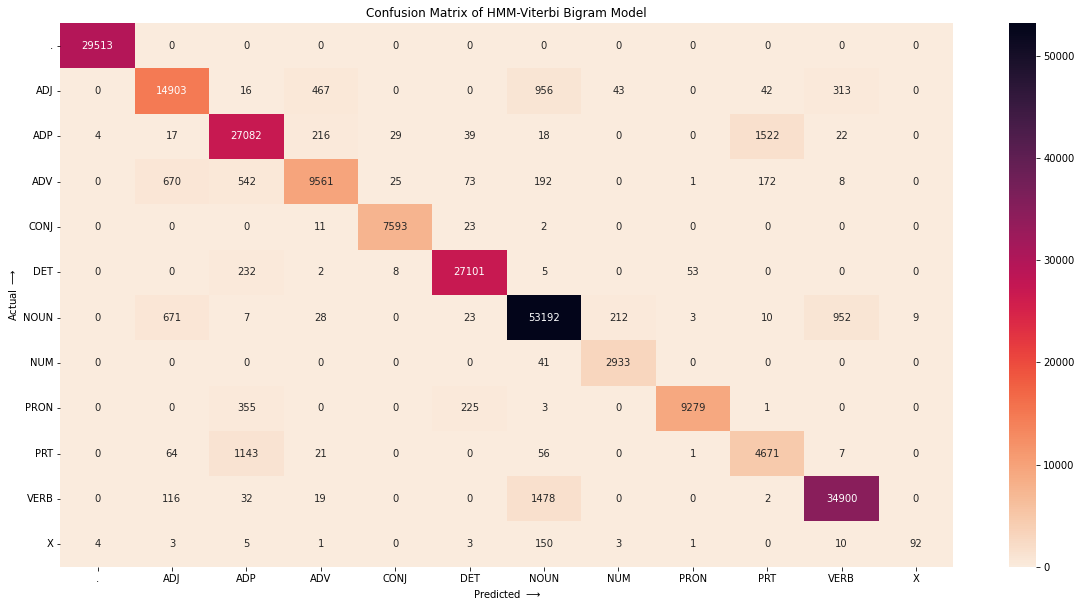

In [14]:
 
df_cm = pd.DataFrame(conf_mats[5], index = tags, columns = tags)
df_cm
fig=plt.figure(figsize = (20,10))
 
 
cmap = sns.cm.rocket_r
ax=sns.heatmap(df_cm, annot=True, yticklabels=allTags , cmap=cmap, fmt='d')
ax.set_xlabel('Predicted '+r'$\longrightarrow$')
ax.set_ylabel('Actual '+r'$\longrightarrow$')
plt.yticks(rotation=0) 
ax.set_title('Confusion Matrix of HMM-Viterbi Bigram Model')
plt.show()



# Generating the Overall Satistical Measures

In [15]:
# Gatehring measures for 5-folds 
overall_metrics = []
for i in range(5):
    overall_metrics.append(metrics.precision_recall_fscore_support(actual_tags[i], predicted_tags[i],labels=tags,average="macro"))

# Aggregating measures across 5-folds
agg_overall_metric = []
# Calculating Precision
agg_overall_metric.append((overall_metrics[0][0]+overall_metrics[1][0]+overall_metrics[2][0]+overall_metrics[3][0]+overall_metrics[4][0])/5)
# Calculating Recall
agg_overall_metric.append((overall_metrics[0][1]+overall_metrics[1][1]+overall_metrics[2][1]+overall_metrics[3][1]+overall_metrics[4][1])/5)
# Calculating F-1-Score
agg_overall_metric.append((2*agg_overall_metric[0]*agg_overall_metric[1])/(agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-0.5-Score
agg_overall_metric.append((1.25*agg_overall_metric[0]*agg_overall_metric[1])/(0.25 *agg_overall_metric[0]+agg_overall_metric[1]))
# Calculating F-2-Score
agg_overall_metric.append((5*agg_overall_metric[0]*agg_overall_metric[1])/(4*agg_overall_metric[0]+agg_overall_metric[1]))


print(agg_overall_metric)
# print([i for i in range(100000)])

[0.9306947620715034, 0.8852811075896474, 0.9074200858718273, 0.9212430717114958, 0.8940057876023699]


# Plotting Overall measures

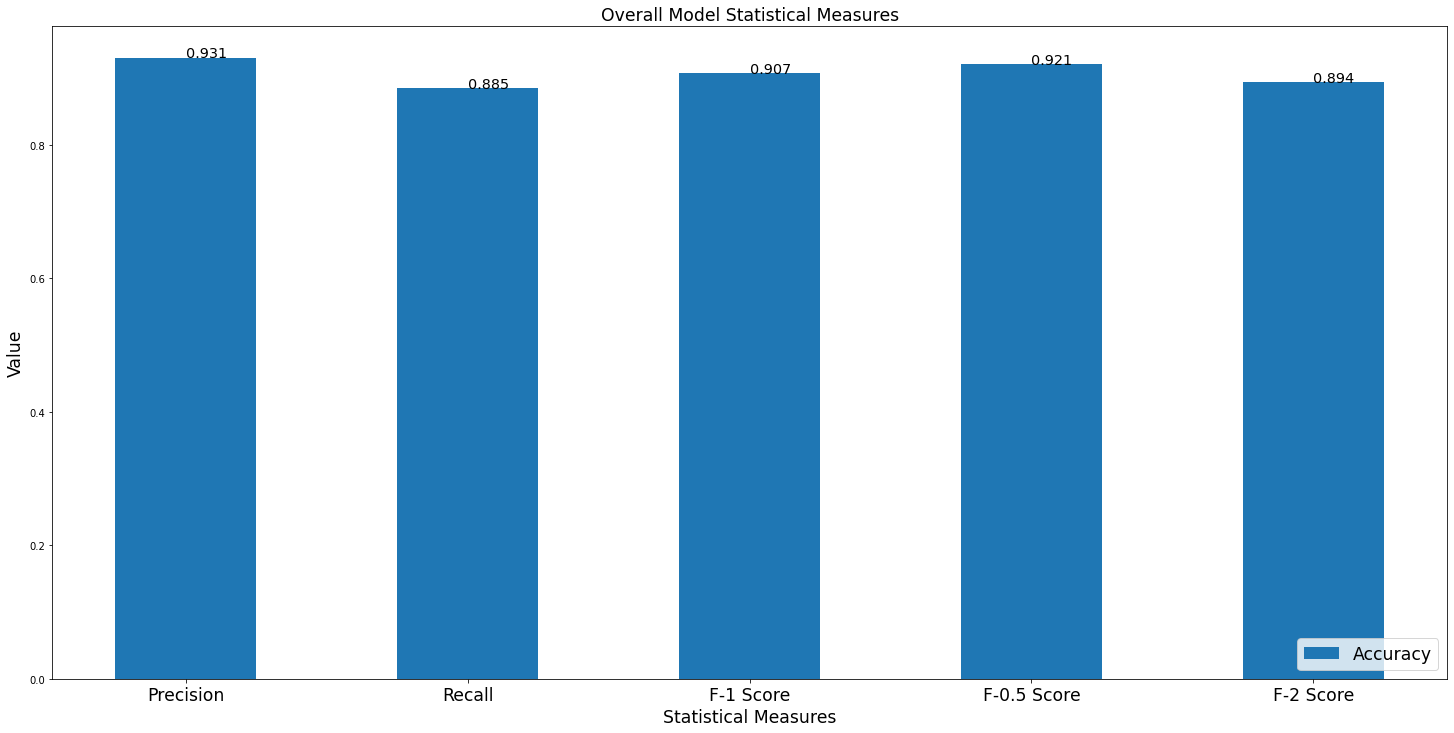

In [16]:
def adding_labels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i],fontsize='x-large')
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [25, 12]


width = 0.5

bar_1 =np.arange(5)
plt.bar(bar_1,agg_overall_metric,width,label="Accuracy")


adding_labels(["Precision","Recall","F-1 Score","F-0.5 Score","F-2 Score"], [round(x,3) for x in agg_overall_metric])

plt.xlabel("Statistical Measures",fontsize='xx-large')
plt.ylabel("Value",fontsize='xx-large')
plt.title("Overall Model Statistical Measures",fontsize='xx-large')
plt.xticks(bar_1,["Precision","Recall","F-1 Score","F-0.5 Score","F-2 Score"],fontsize='xx-large')
plt.legend(loc='lower right',fontsize='xx-large')


# Generating Per Tag measures

In [17]:
#Gathering meaasures of all 5 folds
tag_metrics = []
for i in range(5):
    tag_metrics.append(metrics.precision_recall_fscore_support(actual_tags[i], predicted_tags[i],labels=tags))

# Aggregating measures for all 5 folds
# print(tag_metrics[0])
tag_metrics.append(tag_metrics[0])
for i in range(len(tag_metrics[0])):
    for j in range(len(tag_metrics[0][0])):
        # print(tag_metrics[0][i][j],"===",tag_metrics[1][i][j],"===",tag_metrics[2][i][j],"===",tag_metrics[3][i][j],"===",tag_metrics[4][i][j],"===",tag_metrics[5][i][j])
        tag_metrics[5][i][j] = (tag_metrics[0][i][j] + tag_metrics[1][i][j] + tag_metrics[2][i][j] + tag_metrics[3][i][j] + tag_metrics[4][i][j])/5

# Plotting the measures of per tag measures

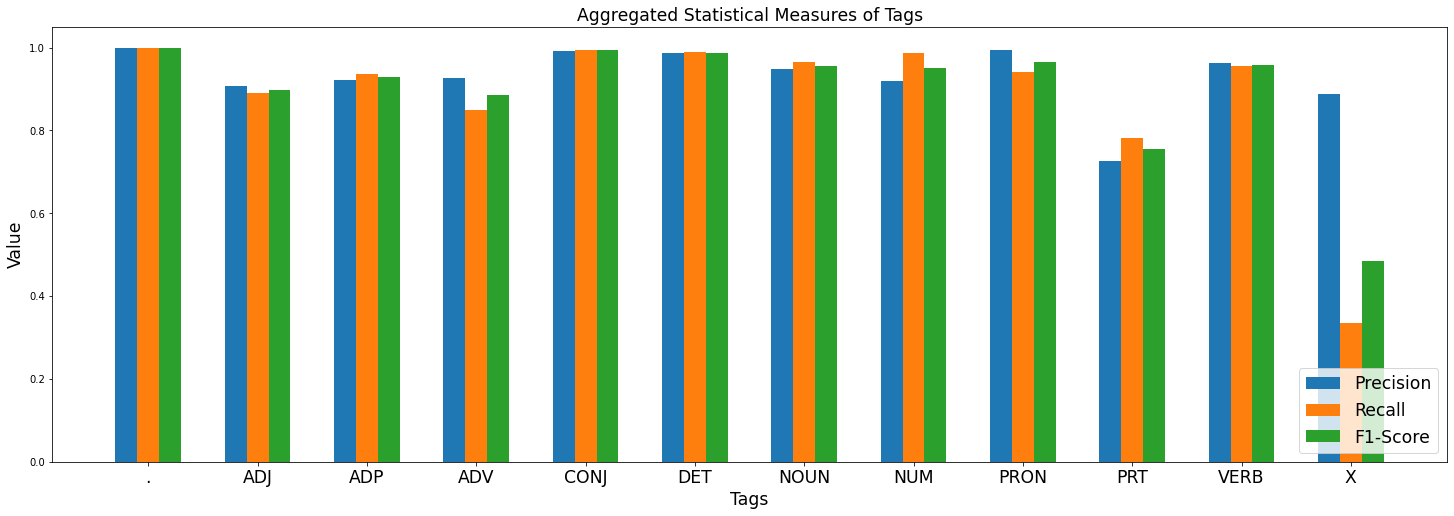

In [18]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [25, 8]

width = 0.2
n=12

bar_1 = np.arange(n)
bar_2 = [i+width for i in bar_1]
bar_3 = [i+width for i in bar_2]
plt.bar(bar_1,tag_metrics[5][0].tolist(),width,label="Precision")
plt.bar(bar_2,tag_metrics[5][1].tolist(),width,label="Recall")
plt.bar(bar_3,tag_metrics[5][2].tolist(),width,label="F1-Score")



plt.xlabel("Tags",fontsize='xx-large')
plt.ylabel("Value",fontsize='xx-large')
plt.title("Aggregated Statistical Measures of Tags",fontsize='xx-large')
plt.xticks(bar_1+1*width,tags[:n],fontsize='xx-large')
plt.legend(loc='lower right',fontsize='xx-large')


# Interactive Plot for selected tag measures

In [19]:
# %matplotlib inline

from ipywidgets import *
from IPython.display import clear_output

selection = widgets.SelectMultiple(
    options=["Precision","Recall","F-1 Score"],
    value=["Precision"],
    rows=3,
    description='Measure',
    disabled=False
)
button = widgets.Button(
    description='Click to plot',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

output = widgets.Output()
items = [selection,button,output]

def plot(b):
    with output:
        clear_output(True)
        plt.rcParams['figure.figsize'] = [25, 8]

        n=12
        val=selection.value
        # print(val)
        if ( len(val) == 3):
            width = 0.2

            bar_1 = np.arange(n)
            bar_2 = [i+width for i in bar_1]
            bar_3 = [i+width for i in bar_2]
            plt.bar(bar_1,tag_metrics[5][0].tolist(),width,label="Precision")
            plt.bar(bar_2,tag_metrics[5][1].tolist(),width,label="Recall")
            plt.bar(bar_3,tag_metrics[5][2].tolist(),width,label="F1-Score")
            plt.xticks(bar_1+1*width,tags[:n])

        elif ( len(val) == 2):
            width = 0.4

            bar_1 = np.arange(n)
            bar_2 = [i+width for i in bar_1]
            if(val[0]=="Precision"):
                plt.bar(bar_1,tag_metrics[5][0].tolist(),width,label="Precision")
            elif(val[0]=="Recall"):
                plt.bar(bar_1,tag_metrics[5][1].tolist(),width,label="Recall")
            else:
                plt.bar(bar_1,tag_metrics[5][2].tolist(),width,label="F1-Score")
            
            if(val[1]=="Precision"):
                plt.bar(bar_2,tag_metrics[5][0].tolist(),width,label="Precision")
            elif(val[1]=="Recall"):
                plt.bar(bar_2,tag_metrics[5][1].tolist(),width,label="Recall")
            else:
                plt.bar(bar_2,tag_metrics[5][2].tolist(),width,label="F1-Score")
            plt.xticks(bar_1+0.5*width,tags[:n])

        else:
            width = 0.8

            bar_1 = np.arange(n)
            if(val[0]=="Precision"):
                plt.bar(bar_1,tag_metrics[5][0].tolist(),width,label="Precision")
            elif(val[0]=="Recall"):
                plt.bar(bar_1,tag_metrics[5][1].tolist(),width,label="Recall")
            else:
                plt.bar(bar_1,tag_metrics[5][2].tolist(),width,label="F1-Score")
            plt.xticks(bar_1,tags[:n])


        plt.xlabel("Tags")
        plt.ylabel("Value")
        plt.title("Aggregated Statistical Measures of Tags")
        plt.legend(loc='lower right',fontsize='large')
        plt.show()


button.on_click(plot)


HB = HBox([selection,button])
VBox([HB, output])
